# Boosted Trees Regression (BQML)

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA_0708' #add proj name and dataset

In [2]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp
!pip install shap
import shap

# visutalization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.3 MB/s eta 0:00:00


## 1) Import dataset

Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update project name

In [4]:
#update file name
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/FY2024_final_cleaned_data_0725.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)


#df = df_raw.drop(columns = ['DIV_WYG_PPl21_0p0_0d0_12']).copy()
df = df_raw.copy()

df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_CONNl21_0p0_0d0_0,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_ESSl21_0p0_0d0_06,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_0,SC_BUYNOWl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12,Is_NYE
0,1/1/2024,354,-2.127083,-2.561218,-2.131126,-2.219054,-0.878548,-1.277200,-1.827179,-0.867772,...,-2.235557,-1.548635,-1.797475,-2.911631,-1.073318,-2.570865,-1.364773,-0.149078,-0.422285,1
1,1/2/2024,1151,-1.630256,-1.736619,-1.709755,-1.697808,0.174025,-1.543707,-1.183600,-1.021791,...,-0.641649,0.803959,-0.439094,-0.167126,3.593769,-1.396380,-0.491115,-0.911401,-1.143448,0
2,1/3/2024,1259,-1.385984,-0.721011,-0.656327,-1.777236,-1.474490,0.342880,-0.861810,-0.944782,...,-0.070570,0.308007,-0.000537,-0.294314,0.827278,-1.190384,-0.402384,-0.149078,-0.422285,0
3,1/4/2024,1210,-0.998873,-1.075076,-1.428841,-0.799280,-0.135555,-1.003680,0.591990,-0.598239,...,-0.377419,0.269856,-0.251329,-0.809220,0.025377,-1.098147,-0.616248,-0.911401,-0.323945,0
4,1/5/2024,1200,-0.644885,-2.062731,-1.709755,-0.804244,-0.336782,1.086293,-0.471065,-0.136182,...,-0.121712,0.931126,-0.394693,-0.765847,-0.142991,-1.428523,-0.504766,3.905834,0.495558,0


In [5]:
df.columns

Index(['Date', 'A_OC_GOOGLE_SHOPPING', 'C_DIV_BUY_CONNECTEDl21_0p0_0d0_12',
       'C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12', 'C_DIV_BUY_PREMIUMl21_0p0_0d0_0',
       'C_DIV_BUY_SSl21_0p0_0d0_12', 'C_DIV_CONN_DATAl21_0p0_0d0_12',
       'C_DIV_CONN_REMOTEl21_0p0_0d0_12', 'C_DIV_CONN_TRYl21_0p0_0d0_06',
       'C_DIV_GETNOW_CONNl21_0p0_0d0_0', 'C_DIV_GETNOW_ESSl21_0p0_0d0_06',
       'C_DIV_GETNOW_PREMl21_0p0_0d0_06', 'C_DIV_GETNOW_SSl21_0p0_0d0_12',
       'C_PP_PKG_APP_ACCESSl21_0p0_0d0_06', 'C_PP_PKG_CONNECTEDl21_0p0_0d0_12',
       'C_PP_PKG_ESSl21_0p0_0d0_12', 'C_PP_PKG_PREMl21_0p0_0d0_06',
       'C_PP_PKG_REMOTEl21_0p0_0d0_0', 'C_PP_PKG_SCl21_0p0_0d0_06',
       'C_PP_PKG_SSl21_0p0_0d0_06', 'DIV_GMOC_SHOP_ESSl21_0p0_0d0_0',
       'DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0', 'DIV_GMOC_SHOP_SSl21_0p0_0d0_0',
       'DIV_PKG_HDStreamingl21_0p0_0d0_12', 'DIV_PKG_SS_CRASHl21_0p0_0d0_06',
       'DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0', 'DIV_PLANPAGE_CONNl21_0p0_0d0_0',
       'DIV_PLANPAGE_ESSl21_0p0_0

In [6]:
df.describe()

,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,C_DIV_GETNOW_ESSl21_0p0_0d0_06,...,DIV_PLANPAGE_CONNl21_0p0_0d0_0,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_ESSl21_0p0_0d0_06,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_0,SC_BUYNOWl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12,Is_NYE
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,...,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,910.338235,0.007535,-0.019765,0.037180,-0.017849,0.057363,-0.020060,0.022647,0.005096,-0.057669,...,0.014916,0.031044,0.037522,0.092863,0.054021,-0.036597,0.029962,-0.049852,-0.060017,0.007353
std,245.249932,1.006555,0.988928,1.007804,1.005894,1.022379,1.011110,1.005049,1.005011,0.996280,...,1.002519,1.010950,0.984662,1.021925,1.004137,1.020351,0.985967,0.987882,0.965222,0.085749
min,354.000000,-2.127083,-2.561218,-2.131126,-2.219054,-2.263920,-1.543707,-1.907627,-1.483848,-2.257680,...,-2.244080,-2.159038,-1.904715,-2.911631,-1.344676,-2.570865,-1.592288,-0.960060,-1.241789,0.000000
25%,743.750000,-0.654200,-0.773421,-0.726555,-0.678897,-0.677321,-0.647753,-0.583117,-0.713753,-0.798510,...,-0.564937,-0.722048,-0.663712,-0.650601,-0.619962,-0.827585,-0.544581,-0.911401,-0.504236,0.000000
50%,882.000000,0.044462,0.008084,0.116187,0.084356,-0.011723,-0.176107,-0.040097,-0.174687,-0.234567,...,0.040236,0.091822,0.007224,0.022044,-0.173166,-0.022328,-0.115715,-0.149078,-0.323945,0.000000
75%,1016.250000,0.652556,0.730191,0.748244,0.676342,0.564870,0.283266,0.579061,0.451015,0.557819,...,0.491985,0.730838,0.623081,0.752642,0.244165,0.702642,0.321114,0.661905,0.495558,0.000000
max,1828.000000,2.895002,2.707832,2.082586,3.062902,4.183090,4.529839,3.976528,5.292986,3.693644,...,3.730942,2.151931,2.295823,2.898865,3.593769,2.613975,6.657412,4.716816,3.675231,1.000000


In [7]:
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_CONNl21_0p0_0d0_0,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_ESSl21_0p0_0d0_06,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_0,SC_BUYNOWl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12,Is_NYE
0,1/1/2024,354,-2.127083,-2.561218,-2.131126,-2.219054,-0.878548,-1.277200,-1.827179,-0.867772,...,-2.235557,-1.548635,-1.797475,-2.911631,-1.073318,-2.570865,-1.364773,-0.149078,-0.422285,1
1,1/2/2024,1151,-1.630256,-1.736619,-1.709755,-1.697808,0.174025,-1.543707,-1.183600,-1.021791,...,-0.641649,0.803959,-0.439094,-0.167126,3.593769,-1.396380,-0.491115,-0.911401,-1.143448,0
2,1/3/2024,1259,-1.385984,-0.721011,-0.656327,-1.777236,-1.474490,0.342880,-0.861810,-0.944782,...,-0.070570,0.308007,-0.000537,-0.294314,0.827278,-1.190384,-0.402384,-0.149078,-0.422285,0
3,1/4/2024,1210,-0.998873,-1.075076,-1.428841,-0.799280,-0.135555,-1.003680,0.591990,-0.598239,...,-0.377419,0.269856,-0.251329,-0.809220,0.025377,-1.098147,-0.616248,-0.911401,-0.323945,0
4,1/5/2024,1200,-0.644885,-2.062731,-1.709755,-0.804244,-0.336782,1.086293,-0.471065,-0.136182,...,-0.121712,0.931126,-0.394693,-0.765847,-0.142991,-1.428523,-0.504766,3.905834,0.495558,0


Set KPI and date columns

In [8]:
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
date_col = "Date" #@param {type:"string"}

## 2) Run the RBA Model in BQML

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

This model also includes a train/test split of 90/10 using the "data_split_method", "data_split_eval_fraction", and "data_split_col" parameters.

Since this data is time series, we use a sequential split with the date column as the reference point.

We suggest using a train/test split to validate model performance, but for attribution results we suggest running the model on the full dataset.

In [ ]:
# %%bigquery
# CREATE OR REPLACE MODEL `.RBA_demo.RBA_model`  #update project name
# OPTIONS (model_type='boosted_tree_regressor',
#         #data_split_method = 'SEQ', #use these options for train/test splits
#         #data_split_eval_fraction = 0.1,
#         #data_split_col = 'date',
#         input_label_cols = ['y1'],
#         enable_global_explain = True)
# AS SELECT * EXCEPT(date)
#     FROM `.RBA_demo.cleaned_data`
#     #ORDER BY date; #update project name

In [10]:
import xgboost as xgb

# Prepare your features and target variable
X_all = df.drop(columns = [kpi_col,date_col], axis=1)  # Assuming 'y1' is your target variable
y = df[kpi_col]

# Create the XGBoost model
model_all = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_all.fit(X_all, y)

# Evaluate the model on the test data
#y_pred = model_all.predict(X_all)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# Calculate the index for splitting the data (e.g., last 10% for testing)
split_index = int(len(df) * 0.9)

# Split the data into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separate features and target variable for both sets
X_train = train_df.drop([kpi_col, date_col], axis=1)
y_train = train_df[kpi_col]
X_test = test_df.drop([kpi_col, date_col], axis=1)
y_test = test_df[kpi_col]

# Create the XGBoost model
model_train = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_train.fit(X_train, y_train)

# Evaluate the model on the test data
#y_pred_test = model.predict(X_test)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

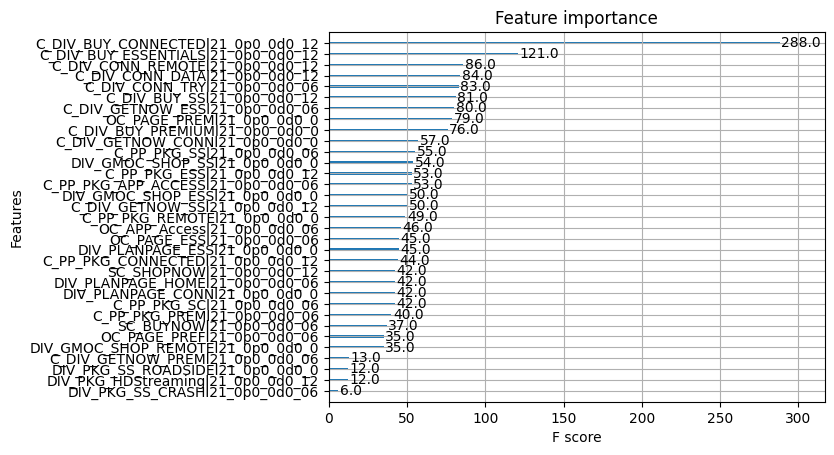

In [12]:
xgb.plot_importance(model_all)

### 2.1) Print the model evaluation metrics

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns: mean absolute error,mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [ ]:
# %%bigquery evaluation_metrics
# SELECT *
# FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [ ]:
# evaluation_metrics

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred_test = model_train.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)


# Print the metrics
print(f"Model Fit Test")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print()



# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred = model_all.predict(X_all)

# Calculate the metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)


print(f"Model Fit All")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")



Model Fit Test
Mean Absolute Error (MAE): 107.88892909458706
Mean Squared Error (MSE): 17014.02481181095
Root Mean Squared Error (RMSE): 130.43781971426444
R-squared (R2): -1.416029489454846

Model Fit All
Mean Absolute Error (MAE): 0.0003404056324678309
Mean Squared Error (MSE): 2.6943299042827944e-07
Root Mean Squared Error (RMSE): 0.0005190693503071429
R-squared (R2): 0.9999999999954873


WARNING: make sure evaluation metrics displayed in Colab match the BQ UI.

### 2.2) Visualize model fit

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [ ]:
# %%bigquery model_predictions
# SELECT
#   *
# FROM
#   ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
#     (
#     SELECT
#         *
#     FROM
#       `.RBA_demo.cleaned_data`
#       ORDER BY date)); #update project name

Visualize the model fit by comparing predicted vs. actual data.

In [14]:
results = pd.DataFrame()
results['actual'] = df[kpi_col]
results['predicted'] = y_pred

In [15]:
fig = px.line(results.sort_index())
fig.show()

## 3) Calculate contribution of each digital media tactic on conversions

To determine feature attribution, we use BQML's Global Explainability methodology. ML.GLOBAL_EXPLAIN provides explanations for the entire model by aggregating the local explanations of the evaluation data

In [ ]:
# %%bigquery feature_importance
# SELECT
#   *
# FROM
#   ML.GLOBAL_EXPLAIN(MODEL `RBA_demo.RBA_model`);

In [ ]:
#feature_importance

In [ ]:
# sum_feature_imp = feature_importance.attribution.sum()
# scale_factor = 0.99 # pulled from BQ UI

# feature_importance['attribution %'] = feature_importance.attribution / (sum_feature_imp / scale_factor)
# feature_importance.sort_values(by = 'attribution %', ascending = False)

In [ ]:
# feature_importance['attribution %'].sum()

In [16]:
# For xgboost
importances = model_all.feature_importances_

feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})


In [17]:
sum_importance = feature_importance.importance.sum()
scale_factor = 0.99  # Adjust as needed

feature_importance['attribution %'] = feature_importance.importance / (sum_importance / scale_factor)
feature_importance.sort_values(by='attribution %', ascending=False, inplace=True)


In [18]:
total_scaled_importance = feature_importance['attribution %'].sum()
print(total_scaled_importance)


0.9899999


## 4) Export Final Results

In [19]:
final_results_df = feature_importance[['feature','attribution %']]
final_results_df.to_csv('rba_final_output_boosted.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_boosted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>